In [1]:
# To allow importing of packages in two directories up
import sys
sys.path.append("../..")

# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mutual_info_score
from tqdm.auto import tqdm
import scipy.stats as sc

import io
import requests

#from core.wca import wca_mean
np.random.seed(21)

In [2]:
def read_HousingData():
    """
        Function to read boston housing data. 
    """
    from sklearn.datasets import load_boston
    boston_dataset = load_boston()
    df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
    df['target']=boston_dataset.target
    y=df['target']
    X=df.drop('target',axis=1)
    return (X,y,df)

In [3]:
# Setting the number of clusters
k=2

# Number of columns to show
col_num = 4

### Random sampling

In [4]:
X, y, df= read_HousingData() 

# Splitting training and testing data
X, X_test, y, y_test = train_test_split(X,y,train_size=0.8,random_state=21)
X.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

# Scaling data
ss = StandardScaler()
cols = X.columns
X = ss.fit_transform(X)
X = pd.DataFrame(data=X,columns=cols)
X_test = ss.transform(X_test)
X_test = pd.DataFrame(data=X_test, columns=cols)
y = pd.Series(ss.fit_transform(y.values.reshape(-1,1)).reshape(-1))
y_test = pd.Series(ss.transform(y_test.values.reshape(-1,1)).reshape(-1))

C_random = dict()
y_random = dict()
for cluster in range(k):
    C_random[cluster] = pd.DataFrame(X[:1])
    y_random[cluster] = y[:1]

# Initializing the p-values
pval_random = dict()
for cluster in range(k):
    pval_random[cluster] = dict()
    for i in C_random[0].columns:
        pval_random[cluster][i] = list()

# Initializing the R2 scores and rmse for cluster 0
r2_random = list()
rmse_random = list()

for i in tqdm(range(int(len(X)/k)), desc = "Iterations: "):
    for cluster in range(k):
        idx = np.random.randint(low=0,high=len(X))
        
        # For data
        C_random[cluster] = C_random[cluster].append(X.iloc[idx])
        X.drop(idx, inplace=True)
        X.reset_index(drop=True,inplace=True)
        C_random[cluster].reset_index(drop=True,inplace=True)
        
        # For target
        y_random[cluster] = y_random[cluster].append(pd.Series(y.iloc[idx]))
        y.drop(idx, inplace=True)
        y.reset_index(drop=True,inplace=True)
        y_random[cluster].reset_index(drop=True,inplace=True)
        
        
        lr = LinearRegression()
        lr.fit(C_random[0],y_random[0])
        r2_random.append(lr.score(X_test,y_test))
        
        y_pred = lr.predict(X_test)
        rmse_random.append(mean_squared_error(y_pred=y_pred,y_true=y_test)**(1/2))
        # For p_value
        for i in C_random[0].columns:
            pval_random[cluster][i].append(sc.ks_2samp(C_random[cluster][i],df.drop('target',axis=1)[i])[1])

### WCA

In [5]:
# Getting the data
X, y, df= read_HousingData() 
X, X_test, y, y_test = train_test_split(X,y,train_size=0.8,random_state=21)
X.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

# Scaling data
ss = StandardScaler()
cols = X.columns
X = ss.fit_transform(X)
X = pd.DataFrame(data=X,columns=cols)
X_test = ss.transform(X_test)
X_test = pd.DataFrame(data=X_test, columns=cols)
y = pd.Series(ss.fit_transform(y.values.reshape(-1,1)).reshape(-1))
y_test = pd.Series(ss.transform(y_test.values.reshape(-1,1)).reshape(-1))


def wca_mean(X, X_test, y, y_test, k, df):
    """
        Implementes the WCA algorithm which maximizes the entropy with respect to the mean of the clusters

        X = Dataframe
        k = number of clusters
    """
    

    # Intializing the clusters
    C = dict()
    y_random = dict()
    for cluster in range(k):
        C[cluster] = pd.DataFrame()

    # Initializing the R2 scores and rmse for cluster 0
    r2 = list()
    rmse = list()
    # Calculating the mean vector
    mean_vector = X.mean()

    # Choosing the seed points based on the minimum distance from the mean vector
    X['dist_mean'] = X.apply(lambda x: np.linalg.norm(np.asarray(x)- np.asarray(mean_vector)), axis=1)
    dist_means = X.sort_values(by='dist_mean')
    
    # Dropping the the datapoints which have already been assigned as seed
    idx_to_drop = dist_means.index[:k]
    dist_means.reset_index(drop=True,inplace=True)
    X.drop('dist_mean',axis=1,inplace=True)
    X.drop(idx_to_drop, inplace=True)
    
    

    # Assigning seed points to the clusters
    mu = list()
    for cluster in range(k):
        C[cluster] = C[cluster].append(dist_means.iloc[cluster].drop('dist_mean'))
        y_random[cluster] = pd.Series(y[idx_to_drop[cluster]])
        mu.append(C[cluster].mean())
        
    y.drop(idx_to_drop, inplace=True)
    
    # Running the algorithm	
    
    # Initializing the p-value list which would be used for plotting
    pval = dict()

    for cluster in range(k):
        pval[cluster] = dict()
        for i in C[0].columns:
            pval[cluster][i] = list()

    # Algorithm
    for i in tqdm(range(int(len(X)/k)), desc='Iterations: '):
        for cluster in range(k):
            
            # Calculating the distances from the mean vector of each cluster (in Descending order)
            X['dist_mean'] = X.apply(lambda x: np.linalg.norm(np.asarray(x)- np.asarray(mu[cluster])), axis=1)
            dist_means = X.sort_values(by='dist_mean', ascending=False)
            idx_to_drop = dist_means.index[0]
            dist_means.reset_index(drop=True,inplace=True)
            X.drop('dist_mean',axis=1,inplace=True)

            # Assigning the top value to the cluster
            C[cluster] = C[cluster].append(dist_means.iloc[0].drop('dist_mean'))
            C[cluster] = C[cluster].reset_index(drop=True)
            
            # Updating means of each cluster
            mu[cluster] = C[cluster].mean()
            
            # Remove datapoint from X?
            X.drop(idx_to_drop,inplace=True)
            X.reset_index(drop=True,inplace=True)
            
            # For target
            y_random[cluster] = y_random[cluster].append(pd.Series(y.iloc[idx_to_drop]))
            y.drop(idx_to_drop, inplace=True)
            y.reset_index(drop=True,inplace=True)
            y_random[cluster].reset_index(drop=True,inplace=True)


            lr = LinearRegression()
            lr.fit(C[0],y_random[0])
            r2.append(lr.score(X_test,y_test))

            y_pred = lr.predict(X_test)
            rmse.append(mean_squared_error(y_pred=y_pred,y_true=y_test)**(1/2))

            for i in C[0].columns:
                pval[cluster][i].append(sc.ks_2samp(C[cluster][i],df.drop('target',axis=1)[i])[1])

    return(C, pval, rmse, r2)



# Running the wca_mean function
C, pval, rmse, r2 = wca_mean(X, X_test, y, y_test, k, df)

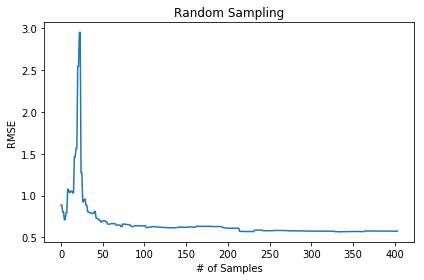

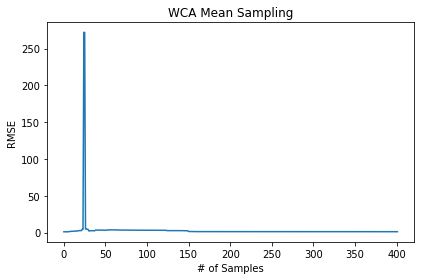

In [6]:
plt.plot(rmse_random)
plt.title("Random Sampling")
plt.xlabel("# of Samples")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()


plt.plot(rmse)
plt.title("WCA Mean Sampling")
plt.xlabel("# of Samples")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()